# LightGBM

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sb 
import matplotlib.pyplot as plt 
import lightgbm as lgb
import time
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from imblearn.over_sampling import ADASYN

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report

import warnings 
warnings.filterwarnings('ignore') 


# 1. Loading data

In [2]:
df = pd.read_csv('datasets/new_german_credit.csv')
df.head()

,STT,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,Telephone
0,0,1,1,18,3,2,1049,1,1,4,1,2,21,2,1,1,2,1
1,1,1,1,9,3,0,2799,1,2,2,2,1,36,2,1,2,2,1
2,2,1,2,12,2,0,841,2,3,2,1,1,23,2,1,1,1,1
3,3,1,1,12,3,0,2122,1,2,3,2,1,39,2,1,2,1,1
4,4,1,1,12,3,0,2171,1,2,4,2,2,38,1,2,2,1,1


In [3]:
df.shape

(1000, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   STT                                1000 non-null   int64
 1   Creditability                      1000 non-null   int64
 2   Account Balance                    1000 non-null   int64
 3   Duration of Credit (month)         1000 non-null   int64
 4   Payment Status of Previous Credit  1000 non-null   int64
 5   Purpose                            1000 non-null   int64
 6   Credit Amount                      1000 non-null   int64
 7   Value Savings/Stocks               1000 non-null   int64
 8   Length of current employment       1000 non-null   int64
 9   Instalment per cent                1000 non-null   int64
 10  Sex & Marital Status               1000 non-null   int64
 11  Most valuable available asset      1000 non-null   int64
 12  Age (years)          

In [5]:
df.describe() 

,STT,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,Telephone
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,499.500000,0.700000,2.183000,20.903000,2.292000,1.557000,3271.24800,1.874000,2.44600,2.973000,1.732000,2.358000,35.54200,1.814000,1.928000,1.367000,1.92600,1.404000
std,288.819436,0.458487,0.835589,12.058814,0.620581,1.296315,2822.75176,1.196476,1.10558,1.118715,0.616893,1.050209,11.35267,0.389301,0.530186,0.482228,0.60406,0.490943
min,0.000000,0.000000,1.000000,4.000000,1.000000,0.000000,250.00000,1.000000,1.00000,1.000000,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.00000,1.000000
25%,249.750000,0.000000,1.000000,12.000000,2.000000,0.000000,1365.50000,1.000000,2.00000,2.000000,1.000000,1.000000,27.00000,2.000000,2.000000,1.000000,2.00000,1.000000
50%,499.500000,1.000000,2.000000,18.000000,2.000000,2.000000,2319.50000,1.000000,2.00000,3.000000,2.000000,2.000000,33.00000,2.000000,2.000000,1.000000,2.00000,1.000000
75%,749.250000,1.000000,3.000000,24.000000,3.000000,3.000000,3972.25000,3.000000,4.00000,4.000000,2.000000,3.000000,42.00000,2.000000,2.000000,2.000000,2.00000,2.000000
max,999.000000,1.000000,3.000000,72.000000,3.000000,3.000000,18424.00000,4.000000,4.00000,4.000000,3.000000,4.000000,75.00000,2.000000,3.000000,2.000000,3.00000,2.000000


# 2. EDA

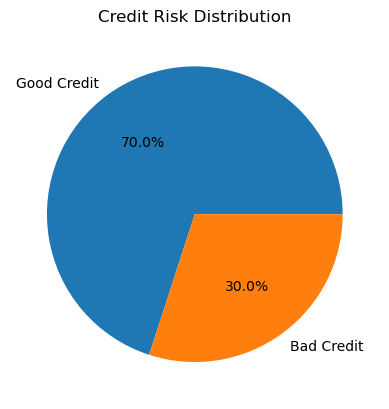

In [6]:
temp = df["Creditability"].value_counts()
# Create a pie chart to represent the distribution 
plt.pie(temp,labels = ["Good Credit", "Bad Credit"], autopct = '%1.1f%%')
plt.title("Credit Risk Distribution")
plt.show()

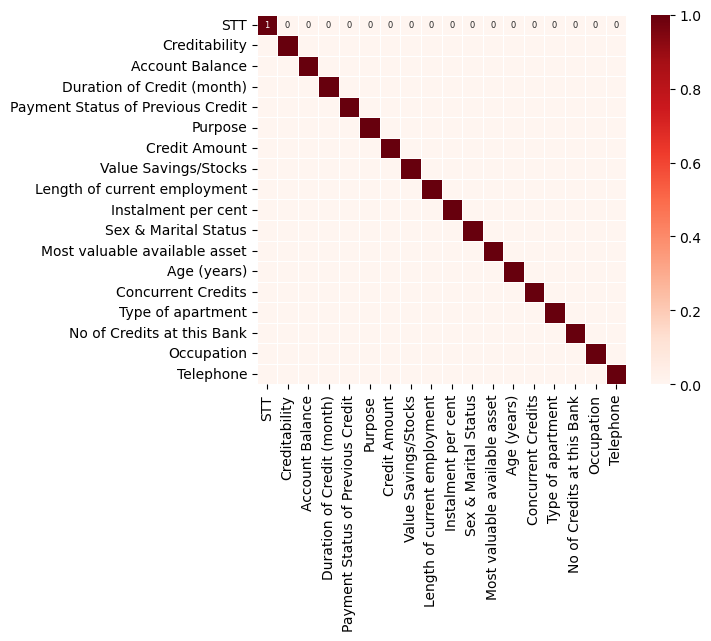

In [7]:
# Compute the correlation matrix and create a heatmap
sb.heatmap(df.corr() > 0.7, annot = True,square= True, linewidths=.5,cmap=plt.cm.Reds,annot_kws={"size":6})
plt.show()

So there are no highly correlated features.

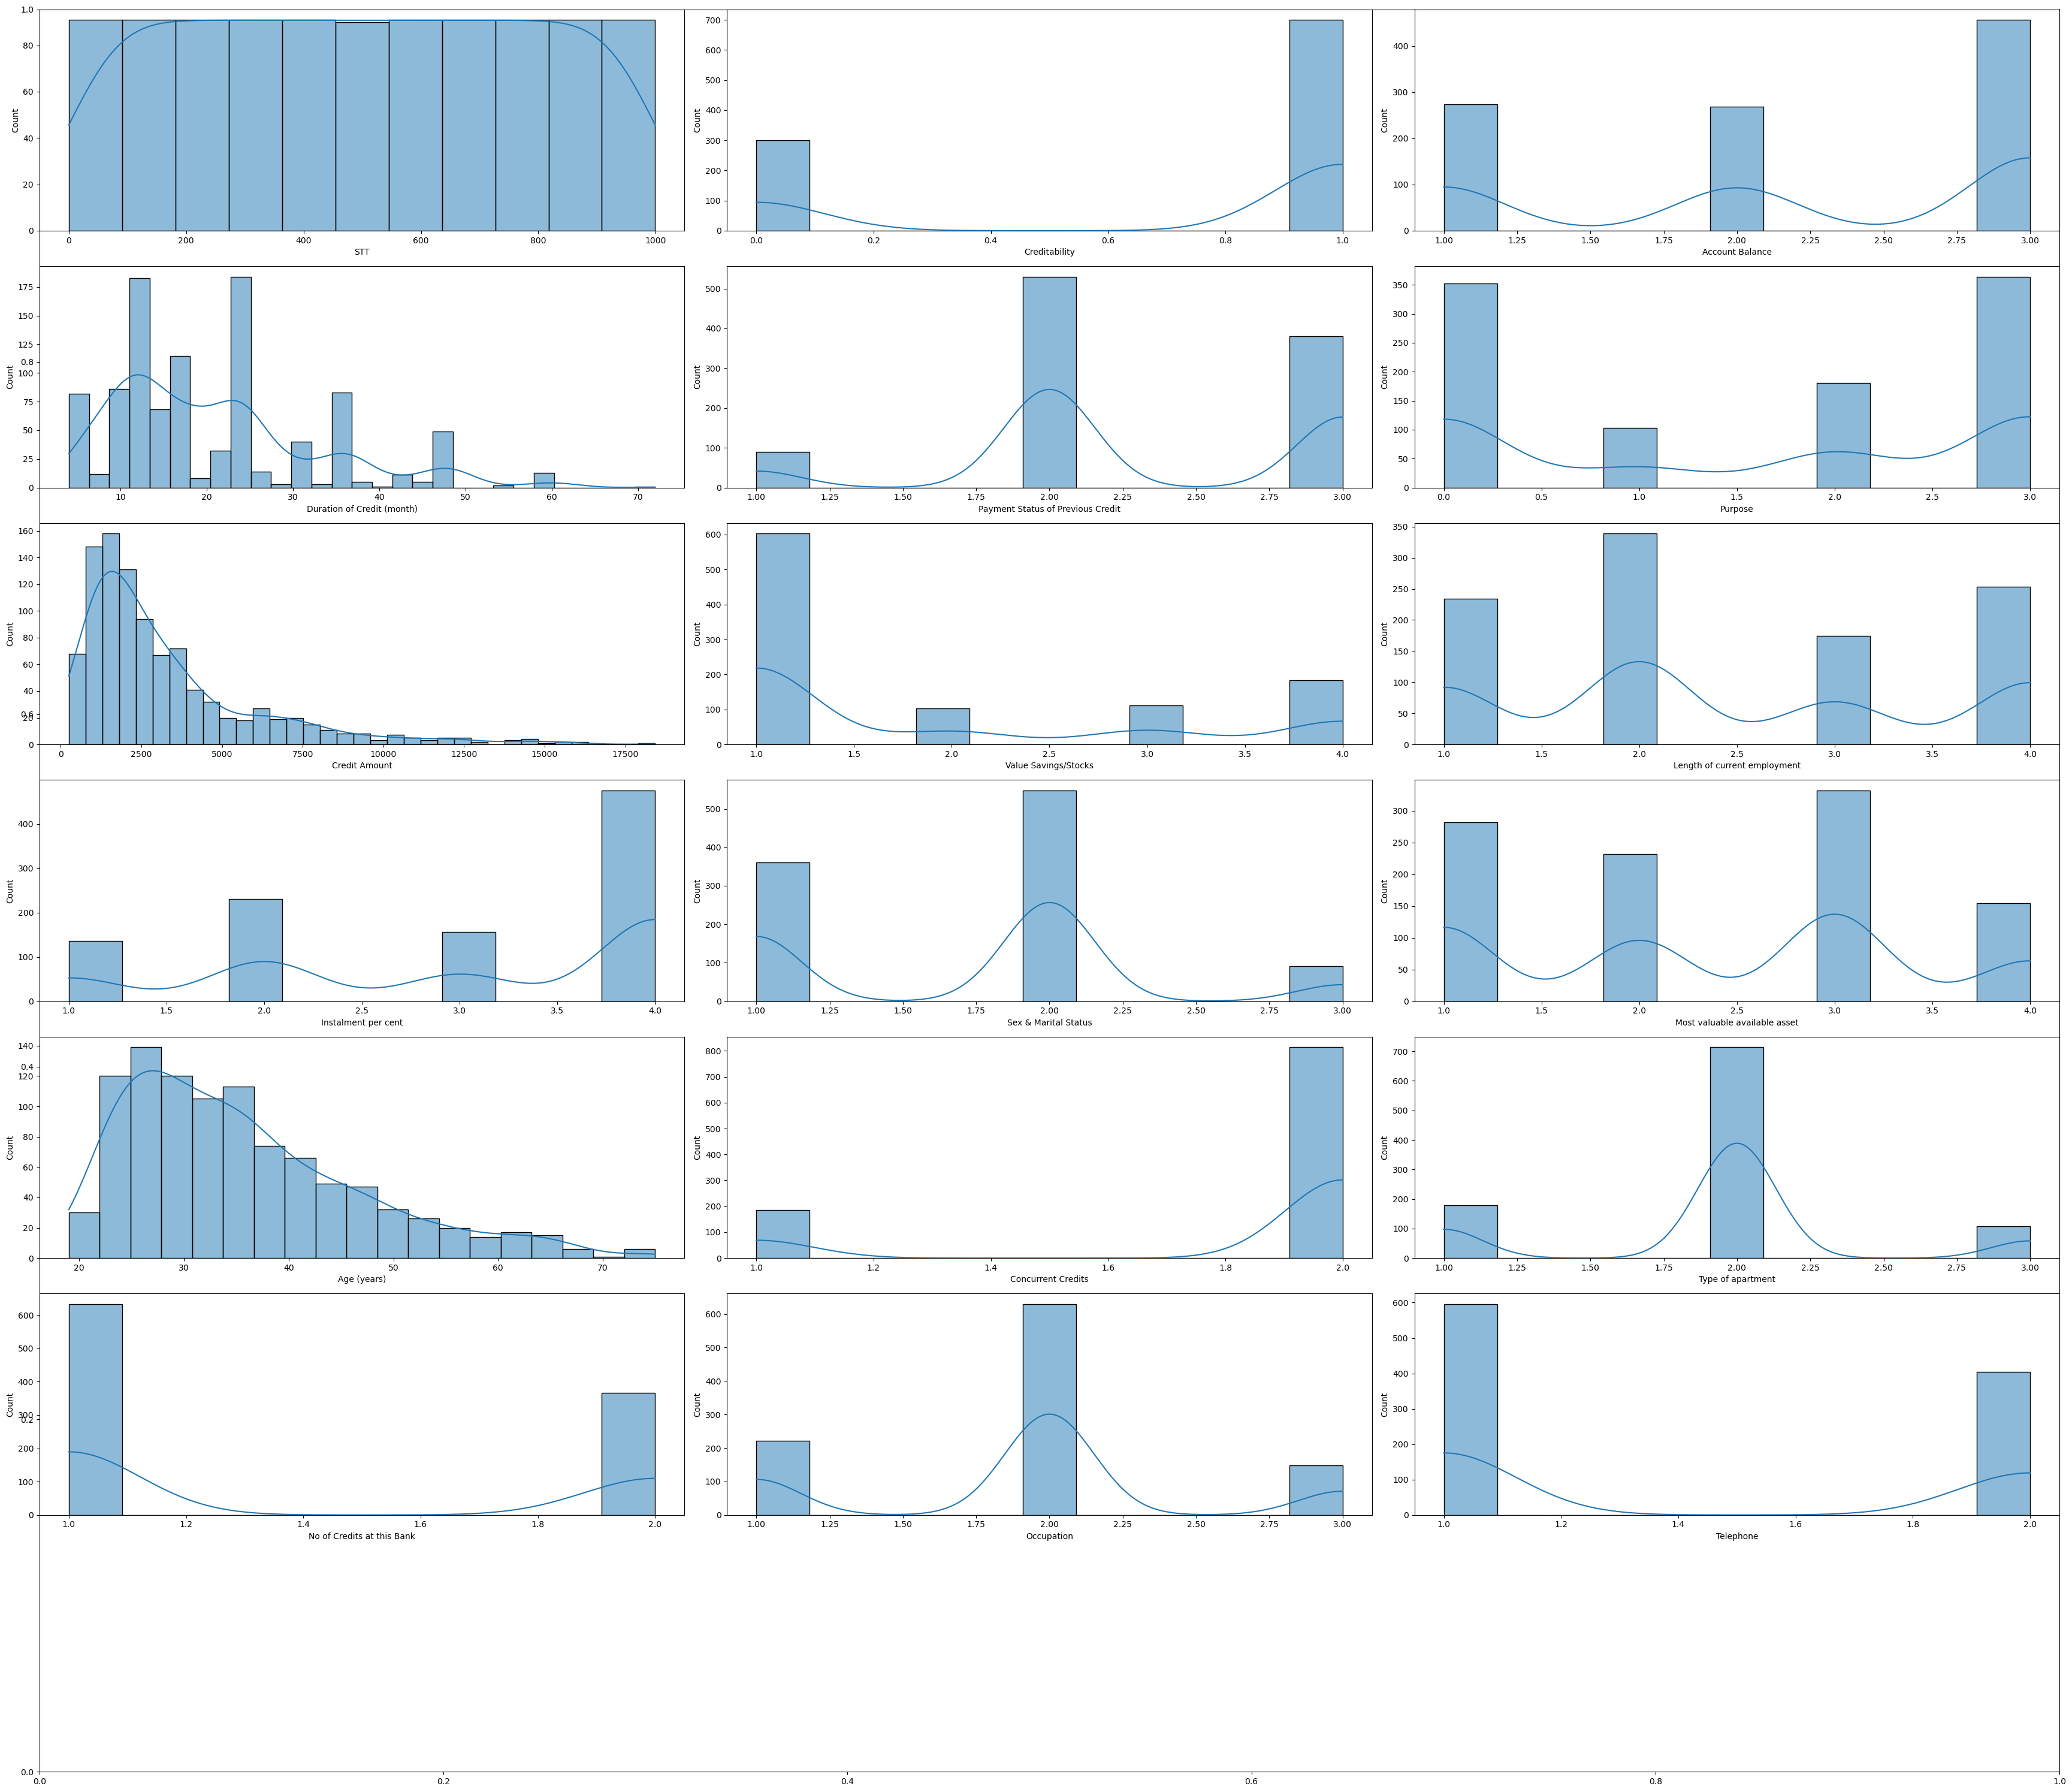

In [8]:
# Create subplots to display distribution plots for each feature
plt.subplots(figsize=(35, 30)) 

for i, col in enumerate(df.columns): 
	plt.subplot(7, 3, i + 1)
	sb.histplot(df[col], kde=True)

plt.tight_layout() # Adjust subplot for better presentation 
plt.show()

# 3. Data Preprocessing

In [9]:
#Splitting data
X = df.drop(['Creditability'], axis = 1)
y = df['Creditability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape 

((800, 17), (200, 17))

In [10]:
# Feature scaling
scaler = StandardScaler() 
scaler.fit(X_train) 
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

# 4. Training

### Hyperparameter tunning

In [11]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# model = lgb.LGBMClassifier()
# param_dist = {
#     'objective': ['binary'],
#     'metric': ['auc'],
#     'boosting_type': ['gbdt'],
#     'num_leaves': [31, 50, 70],  # fewer options to avoid overflow
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 300, 500],
#     'num_round': [100, 200, 300],
#     'min_child_samples': [40],
#     'feature_fraction': [0.9],     # Feature fraction to avoid overfitting
#     'bagging_fraction': [0.8],     # Bagging fraction to avoid overfitting
#     'bagging_freq': [3, 4, 5],
#     'verbose': [-1],
#     'top_rate': [0.1, 0.2], # a in GOSS
#     'other_rate': [0.1, 0.2] # b in GOSS
# }

# # random_search = RandomizedSearchCV(model, param_distributions=param_dist, 
# #                                     n_iter=100, scoring='roc_auc', 
# #                                     cv=3, verbose=1, random_state=42, n_jobs=-1)

# # random_search.fit(X_train, y_train)
# # Initialize GridSearchCV
# grid_search = GridSearchCV(model, param_grid=param_dist, 
#                            scoring='roc_auc', cv=3, 
#                            verbose=1, n_jobs=-1)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# # Evaluate on validation set
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# y_prob = best_model.predict_proba(X_test)[:, 1]

# accuracy = accuracy_score(y_test, y_pred)
# auc = roc_auc_score(y_test, y_prob)

# print(f"Accuracy: {accuracy}")
# print(f"AUC: {auc}")


In [12]:
# from sklearn.model_selection import ParameterGrid
# train_data = lgb.Dataset(X_train, label=y_train)
# test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
# param_grid = {
#     'objective': ['binary'],
#     'metric': ['auc'],
#     'boosting_type': ['gbdt'],
#     'num_leaves': [31, 50, 70],
#     'max_depth': [-1, 5, 10, 15],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 200, 500],
#     'min_child_samples': [20, 50],
#     'feature_fraction': [0.7, 0.8, 0.9],     # Feature fraction to avoid overfitting
#     'bagging_fraction': [0.7, 0.8, 0.9],     # Bagging fraction to avoid overfitting
#     'bagging_freq': [4, 5],           # Frequency for bagging
#     'verbose': [-1],
#     'top_rate': [0.1, 0.2], # a in GOSS
#     'other_rate': [0.1, 0.2], # b in GOSS
#     'num_round': [100, 200, 300]
# }

# param_combinations = list(ParameterGrid(param_grid))
# print('Number of combinations is', len(param_combinations))

# best_params = None
# best_score = -np.inf

# def evaluate_model(params):
#     # Copy parameters and add fixed parameters
#     temp_params = params.copy()

#     bst = lgb.train(params, train_data, temp_params['num_round'], valid_sets=[test_data])
    
#     # Predict on the validation set
#     y_prob = bst.predict(X_test, num_iteration=bst.best_iteration)
#     auc = roc_auc_score(y_test, y_prob)
#     return auc

# # Grid search
# for params in param_combinations:
#     score = evaluate_model(params)
#     if score > best_score:
#         best_score = score
#         best_params = params

# print("Best parameters found: ", best_params)
# print(f"Best AUC: {best_score}")

In [13]:
# Create a LightGBM model
import pickle
start_time = time.time()

acc_scores_train = []
acc_scores_test = []
auc_scores_train = []
auc_scores_test = []

precisions = []
recalls = []
f1s = []

y_test_pred_list = []

# Best parameters found:  {'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'metric': 'auc', 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31, 'num_round': 200, 'objective': 'binary', 'other_rate': 0.1, 'top_rate': 0.1, 'verbose': -1}


params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 70,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,     # Feature fraction to avoid overfitting
    'bagging_fraction': 0.8,     # Bagging fraction to avoid overfitting
    'bagging_freq': 5,           # Frequency for bagging
    'verbose': -1,
    'top_rate': 0.2, # a in GOSS
    'other_rate': 0.1 # b in GOSS
}
num_round = 200

kf = KFold(n_splits=5, shuffle=True, random_state=42)

auc_scores_max = -np.inf
best_model = None

for train_index, test_index in kf.split(X):
    # Apply ADASYN to the training data
    ada = ADASYN(random_state=42)
    X_train,X_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]
    X_train, y_train = ada.fit_resample(X_train, y_train)

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])
    
    # AUC
    y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
    y_test_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
    auc_scores_train.append(roc_auc_score(y_train, y_train_pred))
    auc_scores_test.append(roc_auc_score(y_test, y_test_pred))

    if (roc_auc_score(y_test, y_test_pred) >= auc_scores_max):
        auc_scores_max = roc_auc_score(y_test, y_test_pred)
        best_model = bst


    # Accuracy
    y_train_pred_class = (y_train_pred > 0.5).astype(int)
    y_test_pred_class = (y_test_pred > 0.5).astype(int)
    acc_scores_train.append(accuracy_score(y_train, y_train_pred_class))
    acc_scores_test.append(accuracy_score(y_test, y_test_pred_class))

    report = classification_report(y_test, y_test_pred_class, output_dict=True)
    precisions.append(report['weighted avg']['precision'])
    recalls.append(report['weighted avg']['recall'])
    f1s.append(report['weighted avg']['f1-score'])

    y_test_pred_list.append(y_test_pred)

print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(np.mean(auc_scores_train), np.mean(auc_scores_test)))

print("Accuraccy Train: {:.4f}\nAccuracy Test: {:.4f}".format(np.mean(acc_scores_train), np.mean(acc_scores_test)))

# from sklearn.metrics import confusion_matrix, classification_report

# print(confusion_matrix(y_test, y_test_pred_class))
# print(classification_report(y_test, y_test_pred_class))

AUC Train: 0.9954
AUC Test: 0.9614
Accuraccy Train: 0.9676
Accuracy Test: 0.9210


In [14]:
#Saving infomation
import json
from joblib import dump
best_model.save_model('lightgbm_model.bin')

d = {'Precision': np.mean(precisions),
     'Recall:': np.mean(recalls),
     'F1-score': np.mean(f1s),
     'Accuracy': np.mean(acc_scores_test),
     'AUC': np.mean(auc_scores_test) }

with open('lightgbm_result.json', 'w') as fp:
    json.dump(d, fp)

# Save the scaler to disk
dump(scaler, 'lightgbm_scalar.joblib')

['lightgbm_scalar.joblib']

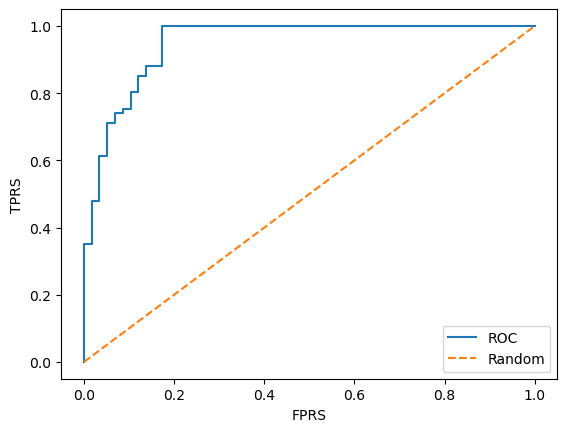

In [15]:
# Draw the ROC curve
a = np.array(y_test_pred_list)
y_test_pred = np.mean(a, axis=0)
fprs, tprs, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fprs, tprs, label = 'ROC')
plt.plot([0,1], [0,1], '--', label = "Random")
plt.legend()
plt.xlabel("FPRS")
plt.ylabel("TPRS")
plt.show()